# Tarea 05 - Imágenes Generativas
## Detección de Anomalías en Imágenes Industriales

Este notebook implementa un sistema de detección de anomalías usando el dataset MVTec AD.


In [ ]:
# Instalación de dependencias necesarias
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install matplotlib numpy scikit-learn opencv-python pillow tqdm wandb pytorch-lightning hydra-core omegaconf


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Definición de Arquitecturas de Modelos

En esta sección se definen las dos arquitecturas de autoencoders que se utilizarán:
- **Autoencoder Clásico**: Arquitectura tradicional sin skip connections
- **U-Net Autoencoder**: Arquitectura con skip connections para mejorar la reconstrucción


In [ ]:
"""
Módulo con las arquitecturas de autoencoders para detección de anomalías
"""
import torch
import torch.nn as nn


class AutoencoderClassic(nn.Module):
    """Autoencoder clásico sin skip connections"""

    def __init__(self, input_channels=3, latent_dim=128, encoder_channels=None, decoder_channels=None, architecture=None):
        super(AutoencoderClassic, self).__init__()
        self.architecture = architecture  # Store for logging purposes

        if encoder_channels is None:
            encoder_channels = [64, 128, 256, 512]
        if decoder_channels is None:
            decoder_channels = [512, 256, 128, 64]

        # Encoder
        encoder_layers = []
        in_channels = input_channels

        for out_channels in encoder_channels:
            encoder_layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(out_channels)
            ])
            in_channels = out_channels

        # Capa final del encoder
        encoder_layers.extend([
            nn.Conv2d(in_channels, latent_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        ])

        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = []
        in_channels = latent_dim

        for out_channels in decoder_channels:
            decoder_layers.extend([
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(out_channels)
            ])
            in_channels = out_channels

        # Capa final del decoder
        decoder_layers.extend([
            nn.ConvTranspose2d(in_channels, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        ])

        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        """Extrae el vector latente de la entrada"""
        return self.encoder(x)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class UNetAutoencoder(nn.Module):
    """Autoencoder U-net con skip connections"""

    def __init__(self, input_channels=3, latent_dim=128, encoder_channels=None, decoder_channels=None, architecture=None):
        super(UNetAutoencoder, self).__init__()
        self.architecture = architecture  # Store for logging purposes

        if encoder_channels is None:
            encoder_channels = [64, 128, 256, 512]
        if decoder_channels is None:
            decoder_channels = [512, 256, 128, 64]

        # Encoder con skip connections
        self.encoder_blocks = nn.ModuleList()
        in_channels = input_channels

        for out_channels in encoder_channels:
            self.encoder_blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(out_channels)
                )
            )
            in_channels = out_channels

        # Capa bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels, latent_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # Decoder con skip connections
        self.decoder_blocks = nn.ModuleList()
        in_channels = latent_dim

        # Primera capa del decoder (sin skip connection)
        self.decoder_blocks.append(
            nn.Sequential(
                nn.ConvTranspose2d(in_channels, decoder_channels[0], kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(decoder_channels[0])
            )
        )
        in_channels = decoder_channels[0]

        # Resto de capas del decoder con skip connections
        for i, out_channels in enumerate(decoder_channels[1:], 1):
            # Duplicar canales de entrada para concatenar con skip connection
            self.decoder_blocks.append(
                nn.Sequential(
                    nn.ConvTranspose2d(in_channels * 2, out_channels, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(out_channels)
                )
            )
            in_channels = out_channels

        # Capa final
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels * 2, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        """Extrae el vector latente de la entrada"""
        # Encoder - guardar skip connections
        skip_connections = []
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)

        # Bottleneck
        x = self.bottleneck(x)
        return x, skip_connections

    def forward(self, x):
        # Encoder - guardar skip connections
        skip_connections = []
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder - usar skip connections
        for i, decoder_block in enumerate(self.decoder_blocks):
            # Concatenar con skip connection correspondiente (en orden inverso)
            skip = skip_connections[-(i+1)]
            # Asegurar que las dimensiones coincidan
            if x.shape[2:] != skip.shape[2:]:
                x = nn.functional.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1)
            x = decoder_block(x)

        # Capa final con último skip connection
        skip = skip_connections[0]
        if x.shape[2:] != skip.shape[2:]:
            x = nn.functional.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.final_layer(x)

        return x

print("✓ Arquitecturas de modelos definidas correctamente")


✓ Arquitecturas de modelos definidas correctamente


### Módulo de Pytorch Lightning

En esta sección se define el módulo de Lightning que encapsula:
- **Funciones de pérdida**: L1, L2, SSIM, SSIM+L1
- **AutoencoderLightning**: Clase que gestiona el entrenamiento, validación y logging automático


In [ ]:
"""
Módulo de Pytorch Lightning para el entrenamiento de autoencoders
"""
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchmetrics import StructuralSimilarityIndexMeasure
import torch.nn.functional as F


class LossFunctions:
    """Funciones de pérdida para el entrenamiento"""

    @staticmethod
    def l1_loss(pred, target):
        return F.l1_loss(pred, target)

    @staticmethod
    def l2_loss(pred, target):
        return F.mse_loss(pred, target)

    @staticmethod
    def ssim_loss(pred, target):
        ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
        ssim_val = ssim(pred, target)
        return 1 - ssim_val  # SSIM es una métrica de similitud, convertimos a pérdida

    @staticmethod
    def ssim_l1_loss(pred, target, alpha=0.5):
        ssim = LossFunctions.ssim_loss(pred, target)
        l1 = LossFunctions.l1_loss(pred, target)
        return alpha * ssim + (1 - alpha) * l1


class AutoencoderLightning(pl.LightningModule):
    """Módulo de Lightning para entrenar autoencoders"""

    def __init__(self, model, learning_rate=0.001, loss_function="L2", scheduler_config=None):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.loss_function = loss_function
        self.scheduler_config = scheduler_config or {"step_size": 10, "gamma": 0.5}

        # Inicializar función de pérdida
        if loss_function == "L1":
            self.criterion = LossFunctions.l1_loss
        elif loss_function == "L2":
            self.criterion = LossFunctions.l2_loss
        elif loss_function == "SSIM":
            self.criterion = LossFunctions.ssim_loss
        elif loss_function == "SSIM_L1":
            self.criterion = LossFunctions.ssim_l1_loss
        else:
            raise ValueError(f"Función de pérdida no reconocida: {loss_function}")

        # Métricas
        self.ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0)

        # Guardar pérdidas de entrenamiento
        self.train_losses = []

        # Guardar hiperparámetros
        self.save_hyperparameters(ignore=['model'])

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x = batch
        x_recon = self(x)
        loss = self.criterion(x_recon, x)

        # Logging
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train/learning_rate', self.optimizers().param_groups[0]['lr'], on_step=True)

        return loss

    def on_train_epoch_end(self):
        # Guardar pérdida promedio de la época
        epoch_loss = self.trainer.callback_metrics.get('train/loss_epoch', None)
        if epoch_loss is not None:
            self.train_losses.append(epoch_loss.item())

    def validation_step(self, batch, batch_idx):
        x = batch
        x_recon = self(x)
        loss = self.criterion(x_recon, x)

        # Calcular SSIM
        ssim_val = self.ssim_metric(x_recon, x)

        # Logging
        self.log('val/loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val/ssim', ssim_val, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=self.scheduler_config.get("step_size", 10),
            gamma=self.scheduler_config.get("gamma", 0.5)
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch"
            }
        }

print("✓ Módulo de Lightning definido correctamente")


✓ Módulo de Lightning definido correctamente


### Configuración con Hydra

En esta sección se configura el proyecto usando **Hydra** para la gestión modular de configuraciones, cumpliendo con los requisitos del enunciado.

**Estructura de configuración (según enunciado)**:
```
conf/
├── config.yaml          # Configuración principal
├── model/               # Configuraciones de modelos
│   ├── autoencoder_classic.yaml
│   └── unet.yaml
├── trainer/             # Configuración del entrenamiento
│   └── default.yaml
└── logger/              # Configuración de WandB
    └── wandb.yaml
```

**Características**:
- ✅ Configuración centralizada en archivos YAML
- ✅ Separación modular de hiperparámetros (modelo, entrenamiento, logger)
- ✅ Permite cambiar hiperparámetros fácilmente usando overrides
- ✅ Integración con WandB para tracking de experimentos
- ✅ Permite ejecutar experimentos con distintos parámetros (dimensión latente, épocas, batch size, etc.)

**Ubicación de archivos**:
- Los archivos de configuración pueden estar en el directorio actual (`/content/conf`) o en Google Drive
- El código busca automáticamente en ambas ubicaciones

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
import cv2
import hydra
from omegaconf import DictConfig, OmegaConf
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

!pip show hydra-core
!pip install --upgrade hydra-core

# Los módulos ya están definidos en las celdas anteriores
# No es necesario importarlos desde archivos externos

# Autenticación de Weights & Biases
import wandb
wandb.login()

# Inicializar Hydra para ejecutar múltiples configuraciones
# En Colab, usamos hydra.initialize() en lugar del decorador @hydra.main
# IMPORTANTE: Hydra requiere que config_path sea una ruta RELATIVA, no absoluta
# Los archivos de configuración deben estar en el directorio de trabajo o en Google Drive

# Configuración: Usar solo Google Drive
# Definir ruta base de Google Drive
DRIVE_BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/Tarea5-IA'
drive_conf_dir = os.path.join(DRIVE_BASE_PATH, 'conf')

# Crear directorio base si no existe
os.makedirs(DRIVE_BASE_PATH, exist_ok=True)

print(f"🔍 Configurando para usar solo Google Drive...")
print(f"   Ruta base: {DRIVE_BASE_PATH}")
print(f"   Configuración: {drive_conf_dir}")

# Verificar si existe en Google Drive
config_file_drive = os.path.join(drive_conf_dir, 'config.yaml')

if os.path.exists(config_file_drive):
    # Usar configuración de Google Drive
    print(f"✓ Usando configuración de Google Drive: {drive_conf_dir}")
    # Copiar temporalmente al directorio actual para Hydra (requiere ruta relativa)
    import shutil
    current_dir = os.getcwd()
    conf_dir_temp = os.path.join(current_dir, 'conf')

    # Limpiar directorio temporal si existe
    if os.path.exists(conf_dir_temp):
        shutil.rmtree(conf_dir_temp)

    # Copiar configuración de Google Drive al directorio temporal
    shutil.copytree(drive_conf_dir, conf_dir_temp)
    print(f"  ✓ Configuración copiada temporalmente a: {conf_dir_temp}")
    config_path_for_hydra = 'conf'  # Ruta relativa
else:
    # Si no existe, crear los archivos de configuración básicos en Google Drive
    print(f"⚠️ No se encontraron archivos de configuración en Google Drive")
    print(f"   Creando estructura y archivos de configuración básicos en: {drive_conf_dir}")

    # Crear estructura de directorios en Google Drive
    os.makedirs(drive_conf_dir, exist_ok=True)
    os.makedirs(os.path.join(drive_conf_dir, 'model'), exist_ok=True)
    os.makedirs(os.path.join(drive_conf_dir, 'trainer'), exist_ok=True)
    os.makedirs(os.path.join(drive_conf_dir, 'logger'), exist_ok=True)

    # Crear archivo config.yaml básico
    config_yaml_content = f"""# Configuración principal del proyecto
defaults:
  - model: autoencoder_classic
  - trainer: default
  - logger: wandb

# Configuración del dataset
dataset:
  path: "{DRIVE_BASE_PATH}/dataset"
  categories: ["cable", "capsule", "screw", "transistor"]
  selected_category: "cable"
  image_size: 128
  batch_size: 32
  num_workers: 2

# Configuración del modelo
# Los parámetros específicos del modelo están en conf/model/

# Configuración del entrenamiento
trainer:
  max_epochs: 20
  learning_rate: 0.001
  loss_function: "L2"
  scheduler:
    step_size: 10
    gamma: 0.5

# Configuración del logger
logger:
  project: "tarea05-anomaly-detection"
  name: null

# Configuración del dispositivo
device: "cuda"
"""

    with open(config_file_drive, 'w', encoding='utf-8') as f:
        f.write(config_yaml_content)
    print(f"  ✓ Creado: config.yaml")

    # Crear archivo autoencoder_classic.yaml
    # NOTA: Las clases están definidas en el notebook y se registran como notebook_models
    autoencoder_yaml = """# Configuración del autoencoder clásico
# NOTA: _target_ apunta a la clase registrada en notebook_models
_target_: notebook_models.AutoencoderClassic

architecture: "autoencoder_classic"

input_channels: 3
latent_dim: 128

encoder_channels: [64, 128, 256, 512]
decoder_channels: [512, 256, 128, 64]
"""
    with open(os.path.join(drive_conf_dir, 'model', 'autoencoder_classic.yaml'), 'w', encoding='utf-8') as f:
        f.write(autoencoder_yaml)
    print(f"  ✓ Creado: model/autoencoder_classic.yaml")

    # Crear archivo unet.yaml
    unet_yaml = """# Configuración del autoencoder U-net con skip connections
# NOTA: _target_ apunta a la clase registrada en notebook_models
_target_: notebook_models.UNetAutoencoder

architecture: "unet"

input_channels: 3
latent_dim: 128

encoder_channels: [64, 128, 256, 512]
decoder_channels: [512, 256, 128, 64]
"""
    with open(os.path.join(drive_conf_dir, 'model', 'unet.yaml'), 'w', encoding='utf-8') as f:
        f.write(unet_yaml)
    print(f"  ✓ Creado: model/unet.yaml")

    # Crear archivo default.yaml para trainer
    trainer_yaml = """# Configuración del entrenador
max_epochs: 20
learning_rate: 0.001
loss_function: "L2"
scheduler:
  step_size: 10
  gamma: 0.5
"""
    with open(os.path.join(drive_conf_dir, 'trainer', 'default.yaml'), 'w', encoding='utf-8') as f:
        f.write(trainer_yaml)
    print(f"  ✓ Creado: trainer/default.yaml")

    # Crear archivo wandb.yaml
    wandb_yaml = f"""# Configuración de WandB
project: "tarea05-anomaly-detection"
name: null
save_dir: "{DRIVE_BASE_PATH}/wandb_logs"
"""
    with open(os.path.join(drive_conf_dir, 'logger', 'wandb.yaml'), 'w', encoding='utf-8') as f:
        f.write(wandb_yaml)
    print(f"  ✓ Creado: logger/wandb.yaml")

    print(f"✓ Estructura de configuración creada en: {drive_conf_dir}")

    # Copiar temporalmente al directorio actual para Hydra
    import shutil
    current_dir = os.getcwd()
    conf_dir_temp = os.path.join(current_dir, 'conf')
    if os.path.exists(conf_dir_temp):
        shutil.rmtree(conf_dir_temp)
    shutil.copytree(drive_conf_dir, conf_dir_temp)
    print(f"  ✓ Configuración copiada temporalmente a: {conf_dir_temp}")
    config_path_for_hydra = 'conf'  # Ruta relativa

# Verificar que el archivo config.yaml existe antes de inicializar Hydra
# Usar el archivo temporal para Hydra
# IMPORTANTE: Definir current_dir ANTES de usarlo
current_dir = os.getcwd()
conf_dir_temp = os.path.join(current_dir, 'conf')
config_file = os.path.join(conf_dir_temp, 'config.yaml')

if not os.path.exists(config_file):
    raise FileNotFoundError(
        f"❌ ERROR: No se pudo crear o encontrar config.yaml\n"
        f"Se esperaba en: {config_file}\n"
        f"Directorio actual: {current_dir}\n"
        f"Por favor, verifica que los archivos estén en Google Drive: {drive_conf_dir}"
    )

print(f"✓ Archivo config.yaml verificado: {config_file}")

# Limpiar Hydra si ya está inicializado (útil si se ejecuta la celda múltiples veces)
from hydra.core.global_hydra import GlobalHydra
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
    print("✓ Limpiando instancia previa de Hydra")

# IMPORTANTE: Asegurarnos de estar en el directorio correcto ANTES de inicializar Hydra
# Hydra usa el directorio de trabajo actual para buscar la configuración
# Si no estamos en el directorio correcto, Hydra buscará en /tmp
os.chdir(current_dir)
actual_dir = os.getcwd()
print(f"✓ Directorio de trabajo configurado: {actual_dir}")

# Verificar que el directorio conf existe en el directorio actual
if not os.path.exists(conf_dir_temp):
    raise FileNotFoundError(
        f"❌ ERROR: No se encontró el directorio conf en {actual_dir}\n"
        f"Se esperaba: {conf_dir_temp}\n"
        f"Por favor, verifica que los archivos de configuración estén en Google Drive: {drive_conf_dir}"
    )

# Verificar que config.yaml existe
if not os.path.exists(config_file):
    raise FileNotFoundError(
        f"❌ ERROR: No se encontró config.yaml en {conf_dir_temp}\n"
        f"Por favor, verifica que los archivos de configuración estén en Google Drive: {drive_conf_dir}"
    )

print(f"✓ Verificado: {config_file} existe")

# Inicializar Hydra con ruta relativa
# Hydra requiere que config_path sea relativa al directorio de trabajo actual
# IMPORTANTE:
# - config_path debe ser 'conf' (sin barra inicial, sin ruta absoluta)
# - El directorio conf debe estar en el directorio de trabajo actual
# - Hydra buscará en: <directorio_actual>/conf/

# Verificar una vez más que estamos en el directorio correcto
final_dir = os.getcwd()
print(f"✓ Directorio final antes de inicializar Hydra: {final_dir}")
print(f"✓ Verificando que conf existe: {os.path.exists(conf_dir_temp)}")
print(f"✓ Verificando que config.yaml existe: {os.path.exists(config_file)}")

# Inicializar Hydra
# IMPORTANTE: Hydra puede cambiar el directorio de trabajo cuando se inicializa
# Para evitar que busque en /tmp, necesitamos asegurarnos de que:
# 1. El directorio de trabajo actual sea /content (donde está conf/)
# 2. El directorio conf/ esté en el directorio de trabajo actual
# 3. Usar job_name para evitar que Hydra cree directorios temporales

# Verificar que estamos en /content
if os.getcwd() != '/content':
    print(f"⚠️ ADVERTENCIA: El directorio de trabajo es {os.getcwd()}, no /content")
    print(f"   Cambiando a /content...")
    os.chdir('/content')
    print(f"   Nuevo directorio: {os.getcwd()}")

# Verificar nuevamente que conf existe
if not os.path.exists('/content/conf'):
    print(f"❌ ERROR: No se encontró /content/conf")
    print(f"   Copiando desde Google Drive...")
    import shutil
    if os.path.exists(drive_conf_dir):
        if os.path.exists('/content/conf'):
            shutil.rmtree('/content/conf')
        shutil.copytree(drive_conf_dir, '/content/conf')
        print(f"   ✓ Copiado a /content/conf")
    else:
        raise FileNotFoundError(f"No se encontró {drive_conf_dir}")

try:
    print(f"✓ Inicializando Hydra con config_path='{config_path_for_hydra}' desde directorio: {os.getcwd()}")
    # Usar job_name para evitar que Hydra cree directorios temporales
    hydra.initialize(config_path=config_path_for_hydra, version_base=None, job_name="notebook")
    print("✓ Hydra inicializado correctamente")
except Exception as e:
    print(f"❌ Error al inicializar Hydra: {e}")
    print(f"   Directorio actual: {os.getcwd()}")
    print(f"   Conf dir esperado: /content/conf")
    print(f"   Conf dir existe: {os.path.exists('/content/conf')}")
    if os.path.exists('/content/conf'):
        print(f"   Contenido de /content/conf: {os.listdir('/content/conf')}")
    raise

# IMPORTANTE: Registrar las clases del notebook en el resolver de Hydra
# Esto permite que instantiate() encuentre las clases definidas en el notebook
from hydra.core.global_hydra import GlobalHydra
from hydra.core.config_store import ConfigStore

# Crear un módulo temporal para registrar las clases
import sys
import types

# Crear un módulo temporal 'notebook_models' que contenga las clases
notebook_models = types.ModuleType('notebook_models')
notebook_models.AutoencoderClassic = AutoencoderClassic
notebook_models.UNetAutoencoder = UNetAutoencoder
sys.modules['notebook_models'] = notebook_models

# Actualizar los archivos YAML para usar notebook_models
# Actualizar tanto en Google Drive como en el directorio temporal
for yaml_file in [os.path.join(drive_conf_dir, 'model', 'autoencoder_classic.yaml'),
                  os.path.join(drive_conf_dir, 'model', 'unet.yaml'),
                  os.path.join(conf_dir_temp, 'model', 'autoencoder_classic.yaml'),
                  os.path.join(conf_dir_temp, 'model', 'unet.yaml')]:
    if os.path.exists(yaml_file):
        with open(yaml_file, 'r', encoding='utf-8') as f:
            content = f.read()
        # Reemplazar _target_ si apunta a AutoencoderClassic o UNetAutoencoder directamente
        if '_target_: AutoencoderClassic' in content or '_target_: UNetAutoencoder' in content:
            content = content.replace('_target_: AutoencoderClassic', '_target_: notebook_models.AutoencoderClassic')
            content = content.replace('_target_: UNetAutoencoder', '_target_: notebook_models.UNetAutoencoder')
            with open(yaml_file, 'w', encoding='utf-8') as f:
                f.write(content)
            print(f"✓ Actualizado: {os.path.basename(yaml_file)}")

print("✓ Clases del notebook registradas para Hydra")

# Componer la configuración (permite override desde parámetros)

print(os.getcwd())
try:
  print(os.path.exists('/content/conf/config.yaml'))
  os.chdir('/content/conf')
  print(os.getcwd())
  cfg = hydra.compose(config_name="config")
except Exception as e:
  print(f"❌ Error al cargar la configuración: {e}")
  raise
print(cfg)

# Ejemplos de cómo usar overrides para cambiar configuraciones:
#
# 1. Cambiar arquitectura a U-net:
#    cfg = hydra.compose(config_name="config", overrides=["model=unet"])
#
# 2. Cambiar función de pérdida:
#    cfg = hydra.compose(config_name="config", overrides=["trainer.loss_function=SSIM"])
#
# 3. Cambiar learning rate:
#    cfg = hydra.compose(config_name="config", overrides=["trainer.learning_rate=0.0005"])
#
# 4. Cambiar dimensión del espacio latente:
#    cfg = hydra.compose(config_name="config", overrides=["model.latent_dim=256"])
#
# 5. Cambiar categoría del dataset:
#    cfg = hydra.compose(config_name="config", overrides=["dataset.selected_category=capsule"])
#
# 6. Múltiples overrides:
#    cfg = hydra.compose(config_name="config", overrides=["model=unet", "trainer.loss_function=SSIM_L1", "trainer.max_epochs=30"])

print("Configuración cargada con Hydra:")
print(OmegaConf.to_yaml(cfg))

# Extraer valores de configuración
DATASET_PATH = cfg.dataset.path
SELECTED_CATEGORY = cfg.dataset.selected_category
IMAGE_SIZE = cfg.dataset.image_size
BATCH_SIZE = cfg.dataset.batch_size
NUM_WORKERS = cfg.dataset.num_workers

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

# La variable DRIVE_BASE_PATH está disponible para todo el notebook
# Se usa para guardar modelos, imágenes, resultados, etc. en Google Drive
print(f'✓ Ruta base de Google Drive configurada: {DRIVE_BASE_PATH}')


Name: hydra-core
Version: 1.3.2
Summary: A framework for elegantly configuring complex applications
Home-page: https://github.com/facebookresearch/hydra
Author: Omry Yadan
Author-email: omry@fb.com
License: MIT
Location: /usr/local/lib/python3.12/dist-packages
Requires: antlr4-python3-runtime, omegaconf, packaging
Required-by: 
🔍 Configurando para usar solo Google Drive...
   Ruta base: /content/drive/MyDrive/Colab Notebooks/Tarea5-IA
   Configuración: /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/conf
✓ Usando configuración de Google Drive: /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/conf
  ✓ Configuración copiada temporalmente a: /content/conf/conf
✓ Archivo config.yaml verificado: /content/conf/conf/config.yaml
✓ Limpiando instancia previa de Hydra
✓ Directorio de trabajo configurado: /content/conf
✓ Verificado: /content/conf/conf/config.yaml existe
✓ Directorio final antes de inicializar Hydra: /content/conf
✓ Verificando que conf existe: True
✓ Verificando que config.yaml 

/usr/local/lib/python3.12/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


{'model': {'_target_': 'notebook_models.AutoencoderClassic', 'architecture': 'autoencoder_classic', 'input_channels': 3, 'latent_dim': 128, 'encoder_channels': [64, 128, 256, 512], 'decoder_channels': [512, 256, 128, 64]}, 'trainer': {'_target_': 'pytorch_lightning.Trainer', 'max_epochs': 20, 'accelerator': 'auto', 'devices': 1, 'precision': 32, 'enable_progress_bar': True, 'log_every_n_steps': 10, 'learning_rate': 0.001, 'loss_function': 'L2', 'scheduler': {'step_size': 10, 'gamma': 0.5}}, 'logger': {'_target_': 'pytorch_lightning.loggers.WandbLogger', 'project': 'tarea05-anomaly-detection', 'name': None, 'save_dir': './wandb_logs'}, 'dataset': {'path': '/content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset', 'categories': ['cable', 'capsule', 'screw', 'transistor'], 'selected_category': 'cable', 'image_size': 128, 'batch_size': 32, 'num_workers': 2}, 'device': 'cuda'}
Configuración cargada con Hydra:
model:
  _target_: notebook_models.AutoencoderClassic
  architecture: autoencoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Carga y Preprocesamiento de Datos

En esta sección se realiza:
- **Carga del dataset MVTec AD**: Se cargan las rutas de las imágenes de entrenamiento y prueba
- **Definición de transformaciones**: Resize a 128x128, normalización y conversión a tensores
- **Creación de DataLoaders**: Preparación de los datos para el entrenamiento con división train/validation (80-20)


In [ ]:
class AnomalyDataset(Dataset):
    """Dataset para cargar imágenes de entrenamiento y prueba"""

    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

def load_dataset_paths(category_path, split='train'):
    """Carga las rutas de las imágenes del dataset"""
    paths = []
    split_path = os.path.join(category_path, split)

    if split == 'train':
        # Solo imágenes 'good' en entrenamiento
        good_path = os.path.join(split_path, 'good')
        if os.path.exists(good_path):
            for img_file in os.listdir(good_path):
                if img_file.endswith('.png'):
                    paths.append(os.path.join(good_path, img_file))
    else:
        # En test, cargar todas las clases (good y defectos)
        if os.path.exists(split_path):
            for class_name in os.listdir(split_path):
                class_path = os.path.join(split_path, class_name)
                if os.path.isdir(class_path):
                    for img_file in os.listdir(class_path):
                        if img_file.endswith('.png'):
                            paths.append(os.path.join(class_path, img_file))

    return paths

# Cargar rutas del dataset
category_path = os.path.join(DATASET_PATH, SELECTED_CATEGORY)
train_paths = load_dataset_paths(category_path, split='train')
test_paths = load_dataset_paths(category_path, split='test')

print(f'Imágenes de entrenamiento: {len(train_paths)}')
print(f'Imágenes de prueba: {len(test_paths)}')


Imágenes de entrenamiento: 224
Imágenes de prueba: 150


In [ ]:
# Transformaciones de datos (usando configuración de Hydra)
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear datasets
train_dataset = AnomalyDataset(train_paths, transform=train_transform)
test_dataset = AnomalyDataset(test_paths, transform=test_transform)

# Crear dataloaders (usando configuración de Hydra)
# Dividir el set de entrenamiento en train y validation (80-20) para WandB
from torch.utils.data import random_split

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset_split, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset_split, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f'Batches de entrenamiento: {len(train_loader)}')
print(f'Batches de validación: {len(val_loader)}')
print(f'Batches de prueba: {len(test_loader)}')


Batches de entrenamiento: 6
Batches de validación: 2
Batches de prueba: 5


## 2.2. Definición del Modelo - Autoencoder Clásico y U-net (Experimento Individual)

Esta sección permite ejecutar **un solo experimento** de forma manual.

**Pasos**:
1. Instanciar el modelo usando Hydra (permite cambiar arquitectura con overrides)
2. Crear el módulo Lightning con la función de pérdida especificada
3. Configurar WandB logger y callbacks

**Nota**: Si ejecutaste la celda de automatización (2.1), puedes saltar esta sección.


## 2.1. Ejecución Automatizada de Experimentos (Opcional)

**⚠️ IMPORTANTE**: Esta celda debe ejecutarse DESPUÉS de haber definido las funciones `AnomalyDataset`, `load_dataset_paths` y `get_anomaly_labels` en las celdas anteriores.

Esta celda ejecuta automáticamente **todos los experimentos requeridos**:
- **2 arquitecturas**: Autoencoder Clásico y U-net
- **4 funciones de pérdida**: L1, L2, SSIM, SSIM_L1
- **Total: 8 experimentos**

**Proceso automatizado**:
1. Itera sobre todas las combinaciones de arquitectura y función de pérdida
2. Entrena cada modelo usando Pytorch Lightning
3. Evalúa el modelo y calcula métricas (AUC-ROC, Average Precision)
4. Registra todo en WandB
5. Genera un resumen comparativo al final

**Nota**: Si prefieres ejecutar un solo experimento, puedes saltar esta celda y usar la sección 2.2.


In [ ]:
# Ejecución automatizada de todos los experimentosimport pandas as pdfrom datetime import datetimefrom pytorch_lightning import Trainerfrom pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitorfrom pytorch_lightning.loggers import WandbLoggerfrom hydra.utils import instantiate# Configuración de experimentosARCHITECTURES = ["autoencoder_classic", "unet"]LOSS_FUNCTIONS = ["L1", "L2", "SSIM", "SSIM_L1"]# Almacenar resultados de todos los experimentosexperiment_results = []print("=" * 80)print("INICIANDO EJECUCIÓN AUTOMATIZADA DE EXPERIMENTOS")print("=" * 80)print(f"Total de experimentos: {len(ARCHITECTURES) * len(LOSS_FUNCTIONS)}")print(f"Arquitecturas: {ARCHITECTURES}")print(f"Funciones de pérdida: {LOSS_FUNCTIONS}")print("=" * 80)# Iterar sobre todas las combinacionesfor arch_idx, architecture in enumerate(ARCHITECTURES):    for loss_idx, loss_function in enumerate(LOSS_FUNCTIONS):        exp_num = arch_idx * len(LOSS_FUNCTIONS) + loss_idx + 1        total_exps = len(ARCHITECTURES) * len(LOSS_FUNCTIONS)                print(f"\n{'='*80}")        print(f"EXPERIMENTO {exp_num}/{total_exps}")        print(f"Arquitectura: {architecture}")        print(f"Función de pérdida: {loss_function}")        print(f"{'='*80}\n")                # Componer configuración con overrides        cfg = hydra.compose(            config_name="config",            overrides=[                f"model={architecture}",                f"trainer.loss_function={loss_function}"            ]        )                # Extraer valores de configuración        DATASET_PATH = cfg.dataset.path        SELECTED_CATEGORY = cfg.dataset.selected_category        IMAGE_SIZE = cfg.dataset.image_size        BATCH_SIZE = cfg.dataset.batch_size        NUM_WORKERS = cfg.dataset.num_workers                # Cargar rutas del dataset        category_path = os.path.join(DATASET_PATH, SELECTED_CATEGORY)        train_paths = load_dataset_paths(category_path, split='train')        test_paths = load_dataset_paths(category_path, split='test')                # Crear transformaciones        train_transform = transforms.Compose([            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),            transforms.ToTensor(),            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])        ])                test_transform = transforms.Compose([            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),            transforms.ToTensor(),            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])        ])                # Crear datasets y dataloaders        train_dataset = AnomalyDataset(train_paths, transform=train_transform)        test_dataset = AnomalyDataset(test_paths, transform=test_transform)                # Dividir train en train y validation (80-20)        from torch.utils.data import random_split        train_size = int(0.8 * len(train_dataset))        val_size = len(train_dataset) - train_size        train_dataset_split, val_dataset = random_split(train_dataset, [train_size, val_size])                train_loader = DataLoader(train_dataset_split, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)                # Instanciar modelo        base_model = instantiate(cfg.model)        base_model = base_model.to(device)                # Crear módulo Lightning        lightning_model = AutoencoderLightning(            model=base_model,            learning_rate=cfg.trainer.learning_rate,            loss_function=cfg.trainer.loss_function,            scheduler_config=cfg.trainer.scheduler        )                # Configurar logger de WandB para este experimento        wandb_logger = WandbLogger(            project=cfg.logger.project,            name=f"{architecture}-{loss_function}-{SELECTED_CATEGORY}",            config=OmegaConf.to_container(cfg, resolve=True),            reinit=True        )                # Callbacks        checkpoint_callback = ModelCheckpoint(            monitor='train/loss_epoch',            checkpoint_dir = os.path.join(DRIVE_BASE_PATH, 'checkpoints', r'{architecture}-{loss_function}')        os.makedirs(checkpoint_dir, exist_ok=True)        dirpath=checkpoint_dir,            filename=f'{architecture}-{loss_function}-{{epoch:02d}}-{{train/loss_epoch:.4f}}',            save_top_k=1,            mode='min'        )                lr_monitor = LearningRateMonitor(logging_interval='step')                # Crear Trainer        trainer = Trainer(            max_epochs=cfg.trainer.max_epochs,            accelerator='auto',            devices=1,            logger=wandb_logger,            callbacks=[checkpoint_callback, lr_monitor],            log_every_n_steps=10,            enable_progress_bar=True        )                # Entrenar con validación        print(f"\nIniciando entrenamiento...")        trainer.fit(lightning_model, train_loader, val_loader)                # Obtener pérdidas de entrenamiento        train_losses = lightning_model.train_losses if hasattr(lightning_model, 'train_losses') else []        final_train_loss = train_losses[-1] if train_losses else None                # Evaluar        print(f"\nEvaluando modelo...")        lightning_model.model.eval()        anomaly_scores = []                with torch.no_grad():            for images in test_loader:                images = images.to(device)                reconstructed = lightning_model.model(images)                mse = torch.mean((images - reconstructed) ** 2, dim=(1, 2, 3))                anomaly_scores.extend(mse.cpu().numpy())                anomaly_scores = np.array(anomaly_scores)                # Obtener etiquetas        test_labels = get_anomaly_labels(test_paths, category_path)                # Calcular métricas        auc_score = roc_auc_score(test_labels, anomaly_scores)        ap_score = average_precision_score(test_labels, anomaly_scores)                # Guardar resultados        result = {            'experiment': exp_num,            'architecture': architecture,            'loss_function': loss_function,            'category': SELECTED_CATEGORY,            'final_train_loss': final_train_loss,            'auc_roc': auc_score,            'average_precision': ap_score,            'min_score': float(anomaly_scores.min()),            'max_score': float(anomaly_scores.max()),            'mean_score': float(anomaly_scores.mean()),            'std_score': float(anomaly_scores.std())        }        experiment_results.append(result)                # Loggear métricas finales en wandb        wandb.log({            "eval/auc_roc": auc_score,            "eval/average_precision": ap_score,            "eval/final_train_loss": final_train_loss if final_train_loss else 0.0        })                # Finalizar wandb run        wandb.finish()                print(f"\n✓ Experimento {exp_num}/{total_exps} completado")        print(f"  AUC-ROC: {auc_score:.4f}")        print(f"  Average Precision: {ap_score:.4f}")        print(f"  Pérdida final: {final_train_loss:.4f if final_train_loss else 'N/A'}")                # Limpiar memoria        del lightning_model        del base_model        del trainer        if torch.cuda.is_available():            torch.cuda.empty_cache()# Crear DataFrame con resultadosresults_df = pd.DataFrame(experiment_results)# Guardar resultadosresults_path = os.path.join(DRIVE_BASE_PATH, 'resultados_experimentos.csv')results_df.to_csv(results_path, index=False)print(f"\n{'='*80}")print("TODOS LOS EXPERIMENTOS COMPLETADOS")print(f"{'='*80}")print(f"\nResultados guardados en: {results_path}")print("\nResumen de resultados:")print(results_df.to_string(index=False))# Crear tabla comparativaprint(f"\n{'='*80}")print("TABLA COMPARATIVA DE RESULTADOS")print(f"{'='*80}")comparison = results_df.pivot_table(    index='architecture',    columns='loss_function',    values=['auc_roc', 'average_precision'],    aggfunc='first')print(comparison)# Guardar tabla comparativacomparison_path = os.path.join(DRIVE_BASE_PATH, 'comparacion_experimentos.csv')comparison.to_csv(comparison_path)print(f"\nTabla comparativa guardada en: {comparison_path}")# Visualizar comparaciónfig, axes = plt.subplots(1, 2, figsize=(15, 6))# Gráfico de AUC-ROCauc_pivot = results_df.pivot_table(    index='architecture',    columns='loss_function',    values='auc_roc',    aggfunc='first')auc_pivot.plot(kind='bar', ax=axes[0], rot=0)axes[0].set_title('Comparación de AUC-ROC por Arquitectura y Función de Pérdida')axes[0].set_ylabel('AUC-ROC')axes[0].legend(title='Función de Pérdida')axes[0].grid(True, alpha=0.3)# Gráfico de Average Precisionap_pivot = results_df.pivot_table(    index='architecture',    columns='loss_function',    values='average_precision',    aggfunc='first')ap_pivot.plot(kind='bar', ax=axes[1], rot=0)axes[1].set_title('Comparación de Average Precision por Arquitectura y Función de Pérdida')axes[1].set_ylabel('Average Precision')axes[1].legend(title='Función de Pérdida')axes[1].grid(True, alpha=0.3)plt.tight_layout()comparison_plot_path = os.path.join(DRIVE_BASE_PATH, 'comparacion_grafica.png')plt.savefig(comparison_plot_path)plt.show()print(f"\n{'='*80}")print("ANÁLISIS COMPLETO")print(f"{'='*80}")print("\nMejor resultado por métrica:")best_auc = results_df.loc[results_df['auc_roc'].idxmax()]print(f"Mejor AUC-ROC: Arquitectura={best_auc['architecture']}, Loss={best_auc['loss_function']}, AUC={best_auc['auc_roc']:.4f}")best_ap = results_df.loc[results_df['average_precision'].idxmax()]print(f"Mejor Average Precision: Arquitectura={best_ap['architecture']}, Loss={best_ap['loss_function']}, AP={best_ap['average_precision']:.4f}")

In [ ]:
# Crear modelo usando instanciación automática de Hydra
# Hydra instanciará automáticamente el modelo según la configuración en conf/model/
from hydra.utils import instantiate

# Instanciar el modelo automáticamente desde la configuración
# Esto usa el _target_ y parámetros definidos en conf/model/autoencoder_classic.yaml o conf/model/unet.yaml
base_model = instantiate(cfg.model)

print(f"Modelo instanciado: {cfg.model._target_}")
print(f"Parámetros del modelo: {sum(p.numel() for p in base_model.parameters())}")

# Crear módulo Lightning con la función de pérdida especificada
lightning_model = AutoencoderLightning(
    model=base_model,
    learning_rate=cfg.trainer.learning_rate,
    loss_function=cfg.trainer.loss_function,
    scheduler_config=cfg.trainer.scheduler
)

print(f"\nArquitectura: {cfg.model.architecture}")
print(f"Función de pérdida: {cfg.trainer.loss_function}")
print(f"Learning rate: {cfg.trainer.learning_rate}")
print(f"Latent dim: {cfg.model.latent_dim}")
print(f"Input channels: {cfg.model.input_channels}")


Modelo instanciado: notebook_models.AutoencoderClassic
Parámetros del modelo: 7614211

Arquitectura: autoencoder_classic
Función de pérdida: L2
Learning rate: 0.001
Latent dim: 128
Input channels: 3


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


## 3.1. Visualizaciones del Set de Validación (Requisitos WandB)

Esta sección genera las visualizaciones requeridas para WandB del set de validación:

1. **Reconstrucciones del set de validación (16 imágenes)**: Comparación lado a lado de imágenes originales vs reconstruidas
2. **t-SNE del espacio latente**: Visualización 2D de cómo el modelo organiza las imágenes en el espacio latente

**Nota**: Estas visualizaciones se registran automáticamente en WandB.


In [ ]:
# El val_loader ya fue creado en la celda anterior
# Continuar con las visualizaciones del set de validación


In [ ]:
# Visualización de reconstrucciones del set de validación (16 imágenes)lightning_model.model.eval()val_images = []val_reconstructions = []val_latent_vectors = []with torch.no_grad():    for batch_idx, images in enumerate(val_loader):        images = images.to(device)                # Obtener reconstrucciones        reconstructed = lightning_model.model(images)                # Extraer vectores latentes        if hasattr(lightning_model.model, 'encode'):            latent = lightning_model.model.encode(images)            # Para UNet, encode devuelve (latent, skip_connections), solo necesitamos latent            if isinstance(latent, tuple):                latent = latent[0]            # Aplanar el vector latente para t-SNE            latent_flat = latent.view(latent.size(0), -1)            val_latent_vectors.append(latent_flat.cpu().numpy())                # Guardar imágenes para visualización (hasta 16)        if len(val_images) < 16:            remaining = 16 - len(val_images)            val_images.append(images[:remaining].cpu())            val_reconstructions.append(reconstructed[:remaining].cpu())                if len(val_images) >= 16:            break# Concatenar todas las imágenesval_images = torch.cat(val_images[:16])[:16]val_reconstructions = torch.cat(val_reconstructions[:16])[:16]# Visualizar 16 reconstrucciones del set de validaciónfig, axes = plt.subplots(4, 8, figsize=(20, 10))axes = axes.flatten()val_reconstruction_images = []for i in range(16):    # Imagen original    img = denormalize(val_images[i].clone())    axes[i*2].imshow(img.permute(1, 2, 0))    axes[i*2].set_title(f'Original {i+1}')    axes[i*2].axis('off')        # Reconstrucción    recon = denormalize(val_reconstructions[i].clone())    axes[i*2+1].imshow(recon.permute(1, 2, 0))    axes[i*2+1].set_title(f'Reconstrucción {i+1}')    axes[i*2+1].axis('off')        # Preparar para wandb    img_np = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)    recon_np = (recon.permute(1, 2, 0).numpy() * 255).astype(np.uint8)    val_reconstruction_images.append(wandb.Image(img_np, caption=f\"Original Val {i+1}\"))    val_reconstruction_images.append(wandb.Image(recon_np, caption=f\"Reconstrucción Val {i+1}\"))plt.tight_layout()validation_recon_path = os.path.join(DRIVE_BASE_PATH, 'validation_reconstructions.png')plt.savefig(validation_recon_path)plt.show()# Loggear en wandbwandb.log({    \"val/reconstructions\": val_reconstruction_images,    \"val/reconstructions_grid\": wandb.Image(validation_recon_path)})print(\"Reconstrucciones del set de validación guardadas en wandb\")

Forma de los vectores latentes: (45, 2048)
Aplicando t-SNE...


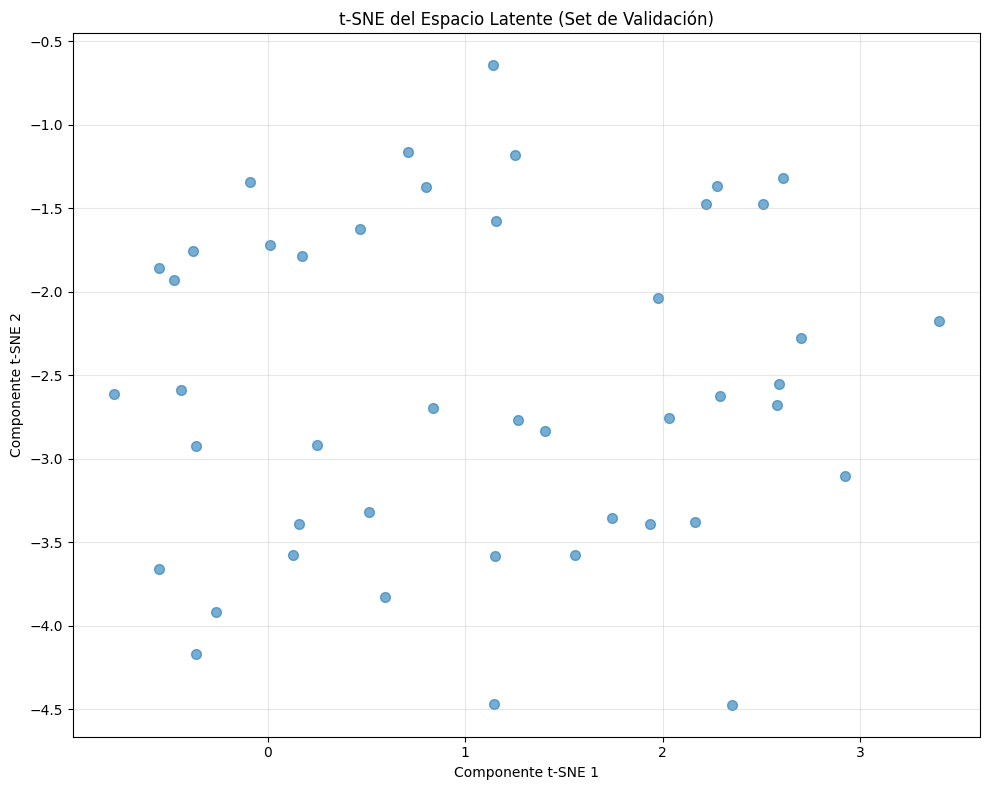

Error al loggear en wandb: You must call wandb.init() before wandb.log()
t-SNE del espacio latente guardado en: /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/tsne_latent_validation.png


In [ ]:
# Visualización t-SNE del espacio latente del set de validación
from sklearn.manifold import TSNE

# Concatenar todos los vectores latentes
if val_latent_vectors:
    all_latent_vectors = np.concatenate(val_latent_vectors, axis=0)

    print(f"Forma de los vectores latentes: {all_latent_vectors.shape}")
    print("Aplicando t-SNE...")

    # Aplicar t-SNE (reducir a 2D para visualización)
    # Asegurarse de que perplexity sea menor que el número de muestras
    perplexity_val = min(30, len(all_latent_vectors) - 1)
    if perplexity_val <= 0: # Handle case with very few samples
        print("No hay suficientes muestras para t-SNE con perplexity > 0.")
    else:
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val)
        latent_2d = tsne.fit_transform(all_latent_vectors)

        # Visualizar t-SNE
        plt.figure(figsize=(10, 8))
        plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.6, s=50)
        plt.title('t-SNE del Espacio Latente (Set de Validación)')
        plt.xlabel('Componente t-SNE 1')
        plt.ylabel('Componente t-SNE 2')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        tsne_path = os.path.join(DRIVE_BASE_PATH, 'tsne_latent_validation.png')
        plt.savefig(tsne_path)
        plt.show()

        # Loggear en wandb (verificar si wandb_logger está definido)
        try:
            if 'wandb_logger' in globals() and wandb_logger is not None:
                wandb_logger.experiment.log({
                    "val/tsne_latent": wandb.Image(tsne_path)
                })
                print("t-SNE del espacio latente guardado en wandb")
            elif 'wandb' in globals():
                wandb.log({
                    "val/tsne_latent": wandb.Image(tsne_path)
                })
                print("t-SNE del espacio latente guardado en wandb")
            else:
                print("t-SNE del espacio latente guardado en:", tsne_path)
                print("Nota: wandb_logger no está definido. Ejecuta primero la celda de entrenamiento para habilitar el logging.")
        except Exception as e:
            print(f"Error al loggear en wandb: {e}")
            print("t-SNE del espacio latente guardado en:", tsne_path)
else:
    print("No se pudieron extraer vectores latentes. Verifica que el modelo tenga método encode().")

## 3. Entrenamiento del Modelo


In [ ]:
# Entrenar modelo usando Pytorch Lightning Trainer
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

# Configurar logger de WandB para Lightning
wandb_logger = WandbLogger(
    project=cfg.logger.project,
    name=f"{cfg.model.architecture}-{cfg.trainer.loss_function}-{SELECTED_CATEGORY}",
    config=OmegaConf.to_container(cfg, resolve=True)
)

# Callbacks
checkpoint_dir = os.path.join(DRIVE_BASE_PATH, 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    monitor='train/loss_epoch',
    dirpath=checkpoint_dir,
    filename=f'{cfg.model.architecture}-{cfg.trainer.loss_function}-{{epoch:02d}}-{{train/loss_epoch:.4f}}',
    save_top_k=1,
    mode='min'
)
lr_monitor = LearningRateMonitor(logging_interval='step')

# Crear Trainer de Pytorch Lightning
trainer = Trainer(
    max_epochs=cfg.trainer.max_epochs,
    accelerator='auto',
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, lr_monitor],
    log_every_n_steps=10,
    enable_progress_bar=True
)

# Entrenar modelo
print(f'Iniciando entrenamiento con Pytorch Lightning...')
print(f'Arquitectura: {cfg.model.architecture}')
print(f'Función de pérdida: {cfg.trainer.loss_function}')
print(f'Learning rate: {cfg.trainer.learning_rate}')
trainer.fit(lightning_model, train_loader, val_loader) # Añadir val_loader para que el logger monitoree 'val/loss'
print('\nEntrenamiento completado!')

# Obtener pérdidas de entrenamiento del modelo Lightning
train_losses = lightning_model.train_losses if hasattr(lightning_model, 'train_losses') else []

# Obtener el modelo base entrenado para evaluación
model = lightning_model.model

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Iniciando entrenamiento con Pytorch Lightning...
Arquitectura: autoencoder_classic
Función de pérdida: L2
Learning rate: 0.001


INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type                              | Params | Mode 
--------------------------------------------------------------------------
0 | model       | AutoencoderClassic                | 7.6 M  | train
1 | ssim_metric | _StructuralSimilarityIndexMeasure | 0      | train
--------------------------------------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.457    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.



Entrenamiento completado!


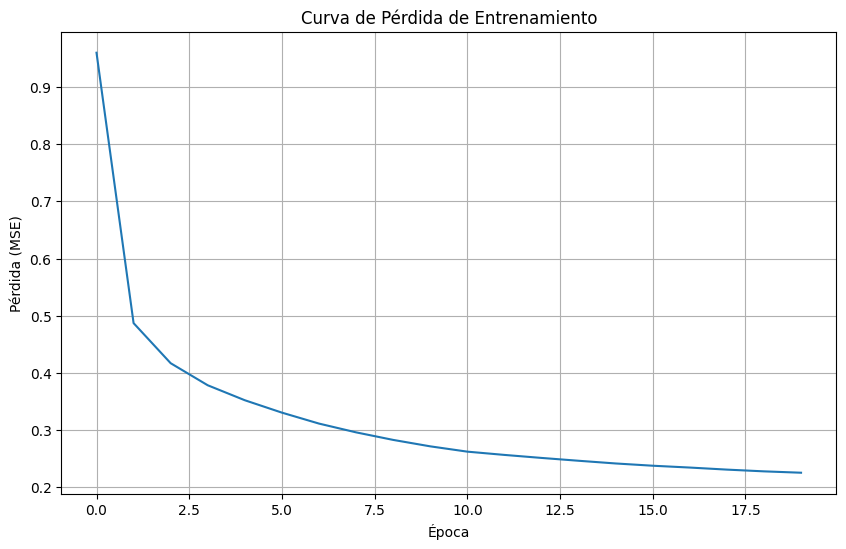

In [ ]:
# Visualizar curva de pérdida
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Curva de Pérdida de Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.grid(True)
train_loss_path = os.path.join(DRIVE_BASE_PATH, 'train_loss_curve.png')
plt.savefig(train_loss_path)
plt.show()

# Loggear la curva de pérdida en wandb
wandb_logger.experiment.log({"train/loss_curve": wandb.Image(train_loss_path)})

## 4. Evaluación y Detección de Anomalías

En esta sección se evalúa el modelo entrenado en el set de prueba:

1. **Cálculo de scores de anomalía**: Se usa el error de reconstrucción (MSE) como métrica
2. **Selección de imágenes**: Se seleccionan 8 imágenes buenas y 8 con anomalías para visualización
3. **Cálculo de métricas**: AUC-ROC y Average Precision
4. **Visualización de curva ROC**: Gráfico de la curva ROC para evaluar el rendimiento

**Métricas calculadas**:
- **AUC-ROC**: Área bajo la curva ROC (mientras más cercano a 1.0, mejor)
- **Average Precision**: Precisión promedio (mientras más cercano a 1.0, mejor)


In [ ]:
def get_anomaly_labels(test_paths, category_path):
    """Obtiene las etiquetas de anomalía (0=normal, 1=anomalía)"""
    labels = []
    good_path = os.path.join(category_path, 'test', 'good')

    for path in test_paths:
        if good_path in path:
            labels.append(0)  # Normal
        else:
            labels.append(1)  # Anomalía

    return np.array(labels)

# Obtener etiquetas de prueba
test_labels = get_anomaly_labels(test_paths, category_path)
print(f'Imágenes normales: {np.sum(test_labels == 0)}')
print(f'Imágenes con anomalías: {np.sum(test_labels == 1)}')


Imágenes normales: 58
Imágenes con anomalías: 92


In [ ]:
# Evaluar modelo en datos de prueba
lightning_model.model.eval()
anomaly_scores = []
test_images_all = []
test_reconstructions_all = []
test_paths_all = []

with torch.no_grad():
    for batch_idx, images in enumerate(test_loader):
        images = images.to(device)
        reconstructed = lightning_model.model(images)

        # Calcular error de reconstrucción (MSE) como score de anomalía
        mse = torch.mean((images - reconstructed) ** 2, dim=(1, 2, 3))
        anomaly_scores.extend(mse.cpu().numpy())

        # Guardar todas las imágenes y reconstrucciones con sus rutas
        batch_start = batch_idx * BATCH_SIZE
        batch_paths = test_paths[batch_start:batch_start + len(images)]
        test_images_all.append(images.cpu())
        test_reconstructions_all.append(reconstructed.cpu())
        test_paths_all.extend(batch_paths)

anomaly_scores = np.array(anomaly_scores)
print(f'Rango de scores: [{anomaly_scores.min():.4f}, {anomaly_scores.max():.4f}]')

# Obtener etiquetas
category_path = os.path.join(DATASET_PATH, SELECTED_CATEGORY)
test_labels = get_anomaly_labels(test_paths_all, category_path)

# Separar imágenes buenas y con anomalías
good_indices = np.where(test_labels == 0)[0]
anomaly_indices = np.where(test_labels == 1)[0]

# Seleccionar 8 imágenes buenas y 8 con anomalías
num_samples = 8
selected_good_indices = good_indices[:num_samples] if len(good_indices) >= num_samples else good_indices
selected_anomaly_indices = anomaly_indices[:num_samples] if len(anomaly_indices) >= num_samples else anomaly_indices

# Concatenar todas las imágenes
all_test_images = torch.cat(test_images_all)
all_test_reconstructions = torch.cat(test_reconstructions_all)

# Seleccionar las 16 imágenes (8 buenas + 8 con anomalías)
selected_indices = np.concatenate([selected_good_indices, selected_anomaly_indices])
sample_images = all_test_images[selected_indices]
sample_reconstructions = all_test_reconstructions[selected_indices]
sample_labels = test_labels[selected_indices]

print(f'Imágenes seleccionadas: {len(selected_good_indices)} buenas + {len(selected_anomaly_indices)} con anomalías = {len(sample_images)} total')

# Loggear estadísticas de scores en wandb
wandb_logger.experiment.log({
    "eval/min_score": float(anomaly_scores.min()),
    "eval/max_score": float(anomaly_scores.max()),
    "eval/mean_score": float(anomaly_scores.mean()),
    "eval/std_score": float(anomaly_scores.std())
})

Rango de scores: [0.1508, 0.3302]
Imágenes seleccionadas: 8 buenas + 8 con anomalías = 16 total


AUC-ROC: 0.6724
Average Precision: 0.7588


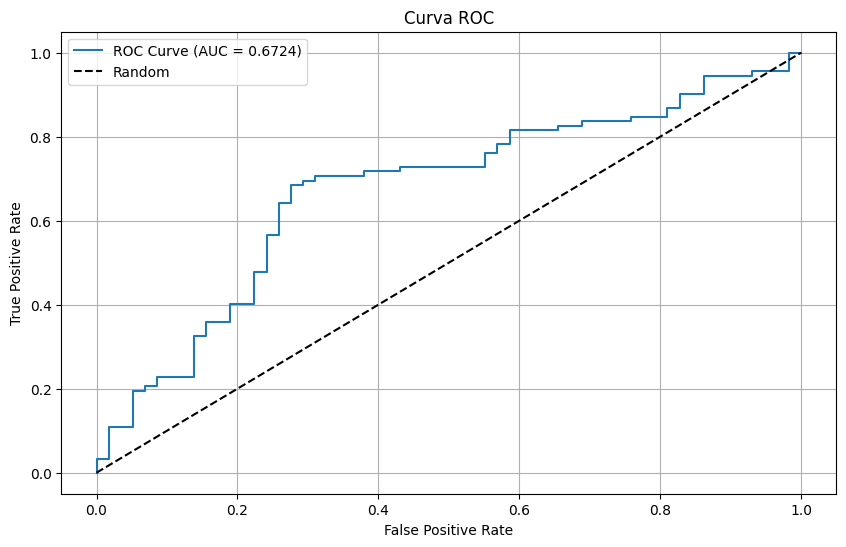

Error al crear curva ROC interactiva en wandb: Found input variables with inconsistent numbers of samples: [150, 2]
La curva ROC estática ya fue guardada correctamente.


In [ ]:
# Calcular métricas
auc_score = roc_auc_score(test_labels, anomaly_scores)
ap_score = average_precision_score(test_labels, anomaly_scores)
print(f'AUC-ROC: {auc_score:.4f}')
print(f'Average Precision: {ap_score:.4f}')

# Curva ROC
fpr, tpr, thresholds = roc_curve(test_labels, anomaly_scores)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
roc_curve_path = os.path.join(DRIVE_BASE_PATH, 'roc_curve.png')
plt.savefig(roc_curve_path)
plt.show()

# Loggear métricas y curva ROC en wandb
wandb_logger.experiment.log({
    "eval/auc_roc": auc_score,
    "eval/average_precision": ap_score,
    "eval/roc_curve": wandb.Image(roc_curve_path)
})

# Crear curva ROC interactiva en wandb
# Nota: wandb.plot.roc_curve requiere que los scores sean probabilidades
# Normalizamos los scores para que estén en [0, 1]
normalized_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min() + 1e-8)

# wandb.plot.roc_curve necesita un formato específico: y_probas debe ser una lista de arrays, uno por clase
# Para binario, necesitamos [prob_clase_0, prob_clase_1] donde prob_clase_1 = normalized_scores
try:
    wandb_logger.experiment.log({
        "eval/roc_curve_interactive": wandb.plot.roc_curve(test_labels,
                                                           [1 - normalized_scores, normalized_scores],
                                                           labels=["Normal", "Anomalía"],
                                                           classes_to_plot=[1])
    })
except Exception as e:
    print(f"Error al crear curva ROC interactiva en wandb: {e}")
    print("La curva ROC estática ya fue guardada correctamente.")

## 5. Visualización de Resultados


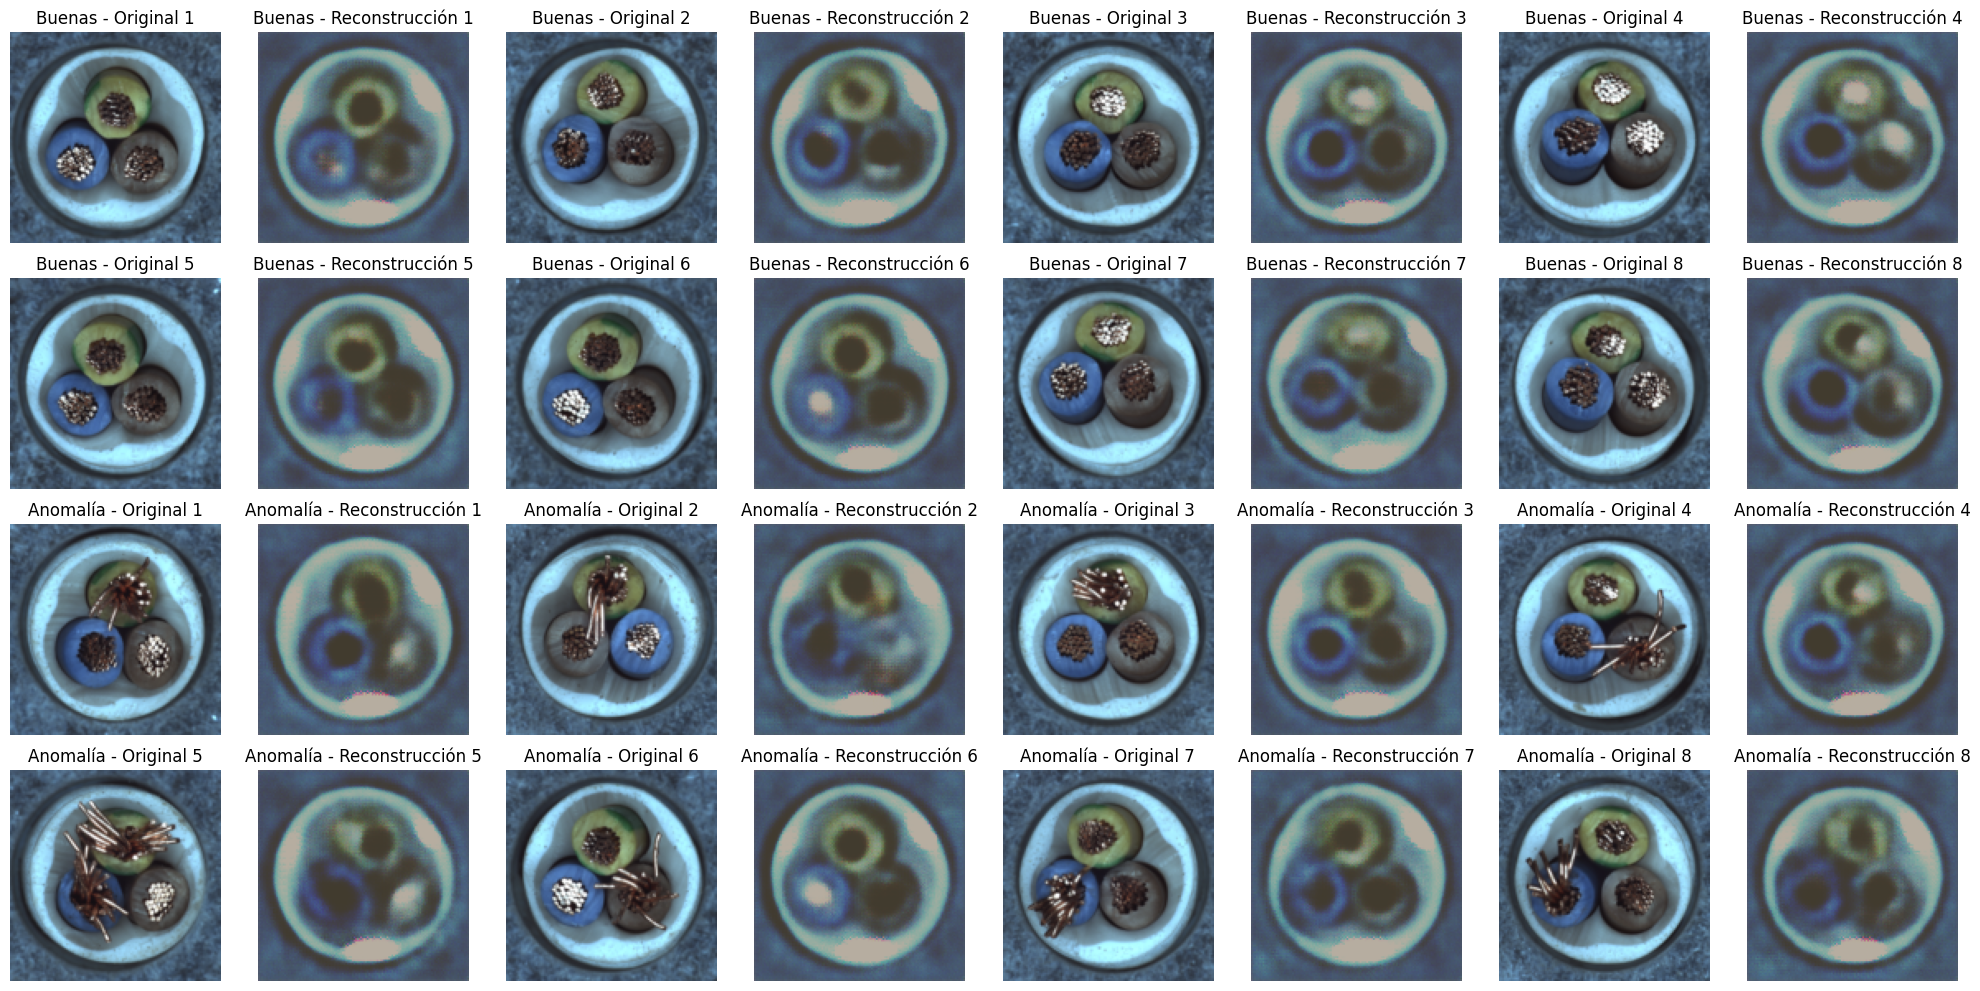

Reconstrucciones del set de prueba (16 imágenes: 8 buenas + 8 con anomalías) guardadas en wandb


In [ ]:
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Desnormaliza un tensor de imagen"""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp_(0, 1)

# Visualizar reconstrucciones del set de prueba (16 imágenes: 8 buenas + 8 con anomalías)
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
test_reconstruction_images = []

# Visualizar 8 imágenes buenas primero
for i in range(8):
    if i < len(sample_images):
        idx = i
        img = denormalize(sample_images[idx].clone())
        recon = denormalize(sample_reconstructions[idx].clone())

        # Imagen original
        axes[i*2].imshow(img.permute(1, 2, 0))
        axes[i*2].set_title(f'Buenas - Original {i+1}')
        axes[i*2].axis('off')

        # Reconstrucción
        axes[i*2+1].imshow(recon.permute(1, 2, 0))
        axes[i*2+1].set_title(f'Buenas - Reconstrucción {i+1}')
        axes[i*2+1].axis('off')

        # Preparar para wandb
        img_np = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        recon_np = (recon.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        test_reconstruction_images.append(wandb.Image(img_np, caption=f"Buenas - Original {i+1}"))
        test_reconstruction_images.append(wandb.Image(recon_np, caption=f"Buenas - Reconstrucción {i+1}"))

# Visualizar 8 imágenes con anomalías
for i in range(8):
    idx = 8 + i
    if idx < len(sample_images):
        img = denormalize(sample_images[idx].clone())
        recon = denormalize(sample_reconstructions[idx].clone())

        # Imagen original
        axes[16 + i*2].imshow(img.permute(1, 2, 0))
        axes[16 + i*2].set_title(f'Anomalía - Original {i+1}')
        axes[16 + i*2].axis('off')

        # Reconstrucción
        axes[16 + i*2+1].imshow(recon.permute(1, 2, 0))
        axes[16 + i*2+1].set_title(f'Anomalía - Reconstrucción {i+1}')
        axes[16 + i*2+1].axis('off')

        # Preparar para wandb
        img_np = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        recon_np = (recon.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        test_reconstruction_images.append(wandb.Image(img_np, caption=f"Anomalía - Original {i+1}"))
        test_reconstruction_images.append(wandb.Image(recon_np, caption=f"Anomalía - Reconstrucción {i+1}"))

plt.tight_layout()
test_recon_path = os.path.join(DRIVE_BASE_PATH, 'test_reconstructions.png')
plt.savefig(test_recon_path)
plt.show()

# Loggear reconstrucciones del set de prueba en wandb
wandb_logger.experiment.log({
    "test/reconstructions": test_reconstruction_images,
    "test/reconstructions_grid": wandb.Image(test_recon_path)
})
print("Reconstrucciones del set de prueba (16 imágenes: 8 buenas + 8 con anomalías) guardadas en wandb")

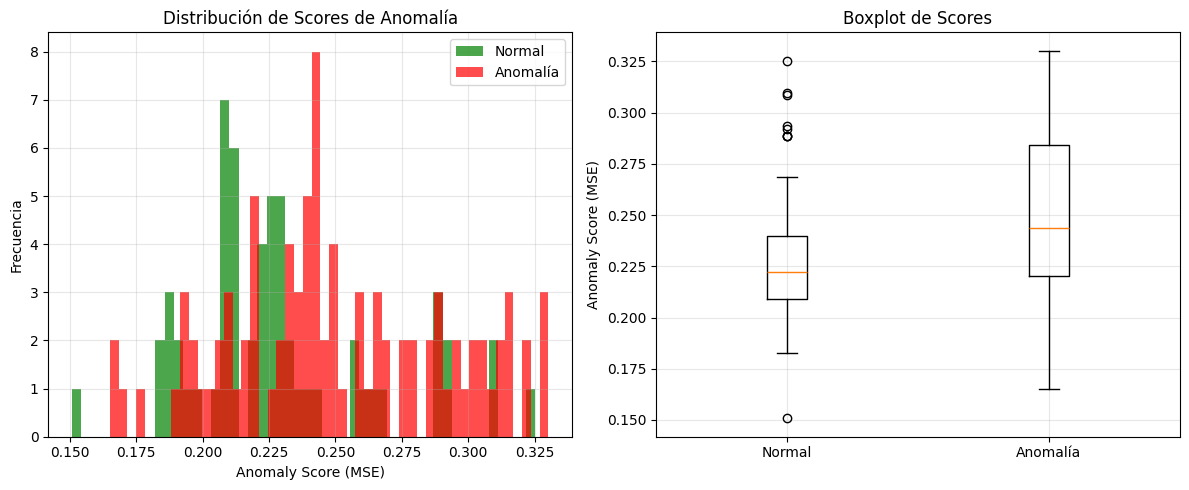

In [ ]:
# Visualizar distribución de scores
normal_scores = anomaly_scores[test_labels == 0]
anomaly_scores_plot = anomaly_scores[test_labels == 1]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(normal_scores, bins=50, alpha=0.7, label='Normal', color='green')
plt.hist(anomaly_scores_plot, bins=50, alpha=0.7, label='Anomalía', color='red')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Scores de Anomalía')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([normal_scores, anomaly_scores_plot], tick_labels=['Normal', 'Anomalía'])
plt.ylabel('Anomaly Score (MSE)')
plt.title('Boxplot de Scores')
plt.grid(True, alpha=0.3)
plt.tight_layout()

score_dist_path = os.path.join(DRIVE_BASE_PATH, 'score_distribution.png')
plt.savefig(score_dist_path)
plt.show()

# Loggear distribución de scores en wandb
wandb_logger.experiment.log({
    "eval/score_distribution": wandb.Image(score_dist_path),
    "eval/normal_scores_mean": float(normal_scores.mean()),
    "eval/normal_scores_std": float(normal_scores.std()),
    "eval/anomaly_scores_mean": float(anomaly_scores_plot.mean()),
    "eval/anomaly_scores_std": float(anomaly_scores_plot.std())
})

# Crear histograma interactivo en wandb
wandb_logger.experiment.log({
    "eval/scores_histogram": wandb.Histogram(anomaly_scores, num_bins=50)
})

In [ ]:
# Encontrar mejores y peores reconstrucciones
sorted_indices = np.argsort(anomaly_scores)

print("Top 5 imágenes con menor error (más normales):")
for idx in sorted_indices[:5]:
    print(f"  {test_paths[idx]} - Score: {anomaly_scores[idx]:.4f}")

print("\nTop 5 imágenes con mayor error (más anómalas):")
for idx in sorted_indices[-5:]:
    print(f"  {test_paths[idx]} - Score: {anomaly_scores[idx]:.4f}")


Top 5 imágenes con menor error (más normales):
  /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset/cable/test/good/054.png - Score: 0.1508
  /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset/cable/test/combined/007.png - Score: 0.1650
  /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset/cable/test/poke_insulation/001.png - Score: 0.1652
  /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset/cable/test/poke_insulation/008.png - Score: 0.1699
  /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset/cable/test/missing_wire/007.png - Score: 0.1774

Top 5 imágenes con mayor error (más anómalas):
  /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset/cable/test/missing_cable/010.png - Score: 0.3206
  /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset/cable/test/good/041.png - Score: 0.3253
  /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset/cable/test/cut_outer_insulation/000.png - Score: 0.3273
  /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dat

## 6. Guardar Modelo


In [ ]:
# Guardar modelo entrenado
model_save_path = os.path.join(DRIVE_BASE_PATH, 'modelo_autoencoder.pth')
torch.save({
    'model_state_dict': lightning_model.model.state_dict(),
    'optimizer_state_dict': lightning_model.optimizers().state_dict(),
    'train_losses': train_losses,
    'auc_score': auc_score,
    'ap_score': ap_score
}, model_save_path)
print(f'Modelo guardado en: {model_save_path}')

# Guardar modelo en wandb
wandb_logger.experiment.save(model_save_path)

# Finalizar wandb run
wandb_logger.experiment.finish()
print("Weights & Biases finalizado. Revisa tus métricas en https://wandb.ai")

wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Modelo guardado en: /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/modelo_autoencoder.pth


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
eval/anomaly_scores_mean,▁
eval/anomaly_scores_std,▁
eval/auc_roc,▁
eval/average_precision,▁
eval/max_score,▁
eval/mean_score,▁
eval/min_score,▁
eval/normal_scores_mean,▁
eval/normal_scores_std,▁
+8,...


Weights & Biases finalizado. Revisa tus métricas en https://wandb.ai


## Notas Finales

- El modelo ha sido entrenado solo con imágenes normales (good)
- Las anomalías se detectan mediante el error de reconstrucción
- Puedes ajustar el umbral de detección según tus necesidades
- Para cargar el modelo guardado, usa: `torch.load(model_save_path)`

### Weights & Biases

- Todas las métricas de entrenamiento y evaluación se registran automáticamente en wandb
- Revisa tus resultados en: https://wandb.ai
- El proyecto se llama: `tarea05-anomaly-detection`
- Cada run se identifica por la categoría utilizada

### Métricas Registradas

- **Entrenamiento**: pérdida por batch, pérdida por época, learning rate
- **Evaluación**: AUC-ROC, Average Precision, estadísticas de scores
- **Visualizaciones**: curva ROC, reconstrucciones, distribución de scores
- **Modelo**: se guarda automáticamente en wandb
